In [219]:
import numpy as np
import os
from skimage.io import imread, imsave
from scipy.signal import savgol_filter
from scipy.optimize import least_squares
import matplotlib.pyplot as plt
from scipy.ndimage import distance_transform_edt

In [265]:
plt.figure(figsize=(6,6))
def save_quivers(outdir, file_pattern1, file_pattern2, w,h, nt, vel, pos, normed=False):
    #pos = self.pos()
    #vel = self.vel()
    for t in range(nt):
        print(t)
        im = images[t]
        plt.imshow(im/np.max(im),cmap='gray', origin='lower')
        if normed:
            norm = np.sqrt(vel[:,:,t,0]**2 + vel[:,:,t,1]**2)
        else:
            norm = 1
        vx = vel[:,:,t,0]
        vy = vel[:,:,t,1]
        plt.quiver(w/2+pos[:,:,t,1],h/2+pos[:,:,t,0], vy/norm, vx/norm,cmap='gray')
        #fname = os.path.join(outdir, file_pattern1%(t))
        #plt.savefig(fname)
        plt.show()
        #plt.clf()
        #plt.quiver(w/2+pos[:,:,t,1],h/2+pos[:,:,t,0], vy/norm, vx/norm)
        #fname = os.path.join(outdir, file_pattern2%(t))
        #plt.savefig(fname)
        #plt.show()
        #plt.clf()

<Figure size 600x600 with 0 Axes>

In [256]:
# Fit an exponential decay model to the velocity data
def residual_func(edt, nvmag, nt, nx, ny):
    def residuals(x):
        r0 = np.exp(x[0])
        C = 0  # x[1]
        res = []
        for frame in range(0,nt):
            for ix in range(nx):
                for iy in range(ny):
                    if not np.isnan(nvmag[frame, ix, iy]) and vfront[frame] > 1:
                        r = edt[frame, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                        #r = edt[t, ix * 16:ix * 16 + 32, iy * 16:iy * 16 + 32]
                        R = rmax[t]
                        B = R / ((R - r0) + r0 * np.exp(-R / r0))    
                        model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
                        #B = 1 / (1 - np.exp(-rmax[t] / r0))
                        #model_vmag = 1 + B * (np.exp(-r / r0) - 1)                    
                        mean_model_vmag = vfront[frame] * np.nanmean(model_vmag)
                        res.append(mean_model_vmag - nvmag[frame, ix, iy])
        return res
    return residuals

#### Displaying velocity results

In [257]:
position = 0
#path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
path = '/media/c1046372/Expansion/Thesis GY/3. Analyzed files'
scope_name = 'Ti scope'
exp_date = '2023_11_17'
velocity_folder = 'velocity_data'
masks_folder = 'contour_masks'
results_folder = 'results'
graphs_folder = 'graphs'
dnas = {'pLPT20&pLPT41': 'pLPT20&41', 'pLPT119&pLPT41': 'pLPT119&41', 'pAAA': 'pAAA', 'pLPT107&pLPT41': 'pLPT107&41'}
scopes = {'Tweez scope': 'TiTweez', 'Ti scope': 'Ti'}
vector = 'pLPT119&pLPT41'
#vector = 'pAAA'

In [258]:
fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{position}.ome.tif'
fname_mask = 'mask_' + fname
path_im = os.path.join(path,scope_name,exp_date,fname)
path_mask = os.path.join(path,scope_name,exp_date,masks_folder,fname_mask)
im = imread(path_im)
mask = imread(path_mask)
fname

'2023_11_17_10x_1.0x_pLPT119&41_Ti_Pos0.ome.tif'

In [259]:
images = im[:,:,:,2]
masks = mask

In [260]:
path_pos = os.path.join(path,scope_name,exp_date,velocity_folder,f"pos{position}",'pos.np.npy')
path_vel = os.path.join(path,scope_name,exp_date,velocity_folder,f"pos{position}",'vel.np.npy')
pos = np.load(path_pos)
vel = np.load(path_vel)

In [261]:
path_edt = os.path.join(path,scope_name,exp_date,results_folder,f"pos{position}",'edt.npy')
edt = np.load(path_edt)

In [262]:
edt.shape

(216, 1200, 1200)

In [263]:
_, _, nt, _ = vel.shape

0


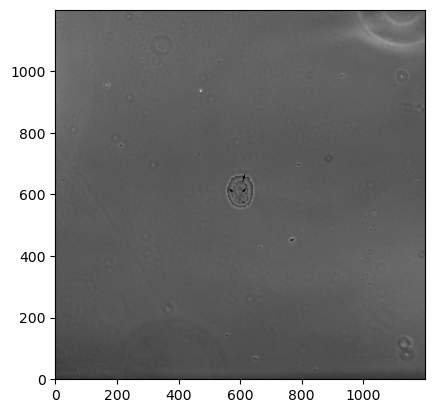

1


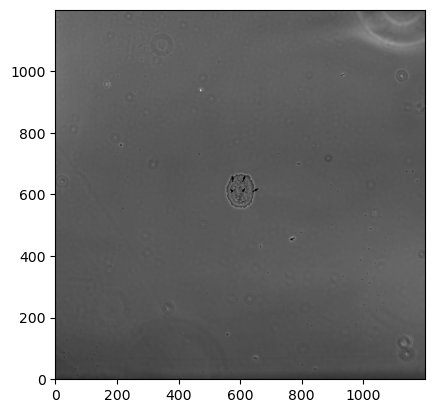

2


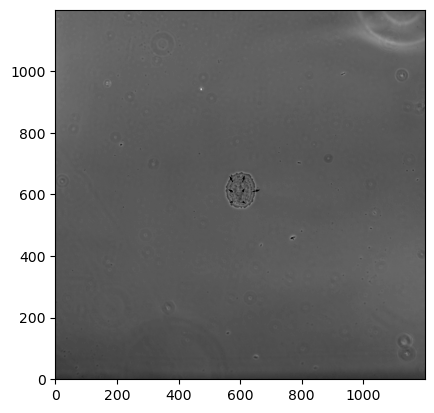

3


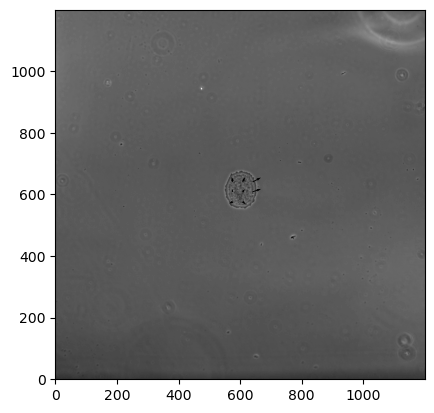

4


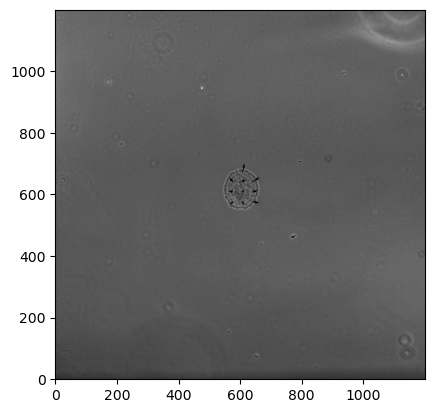

5


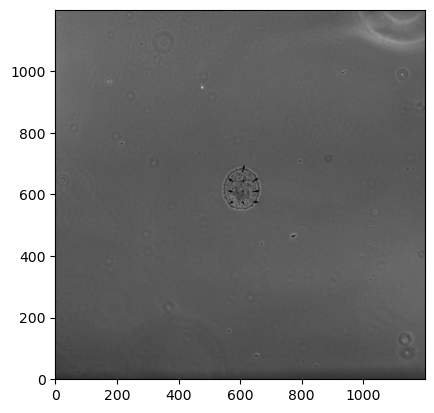

6


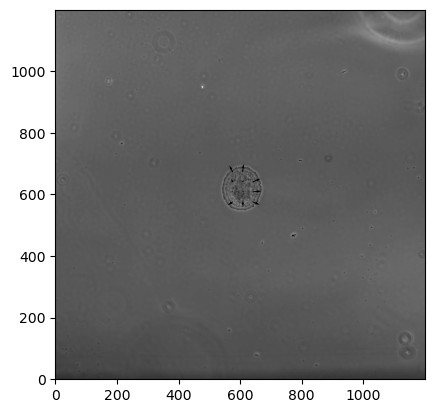

7


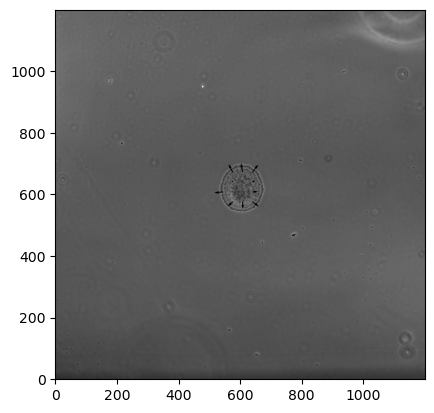

8


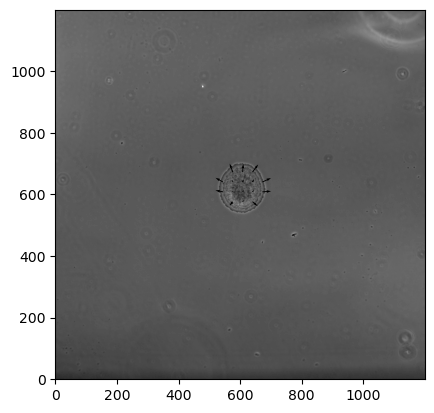

9


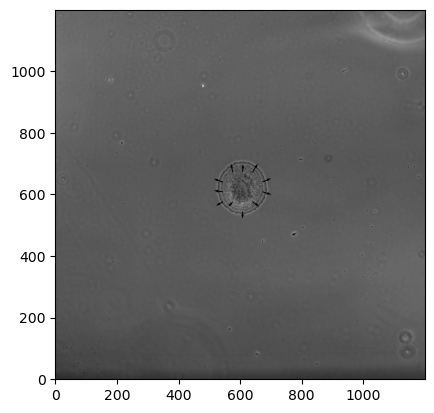

10


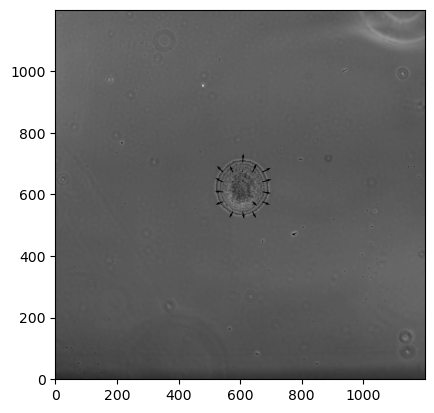

11


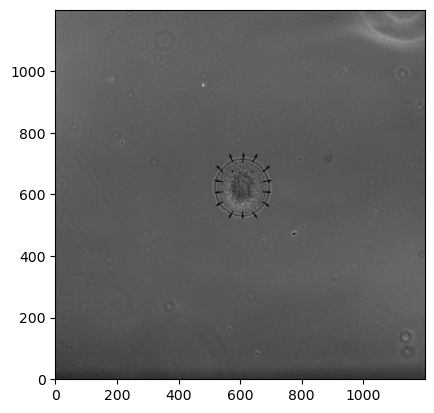

12


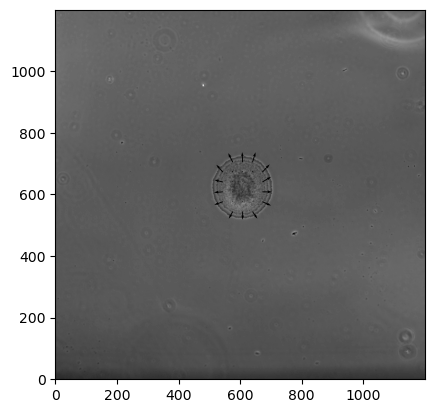

13


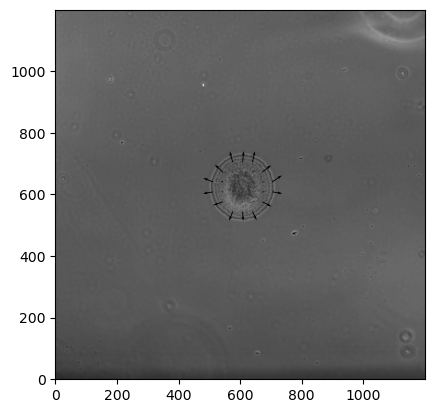

14


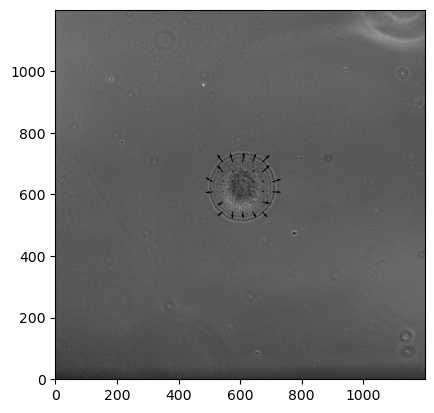

15


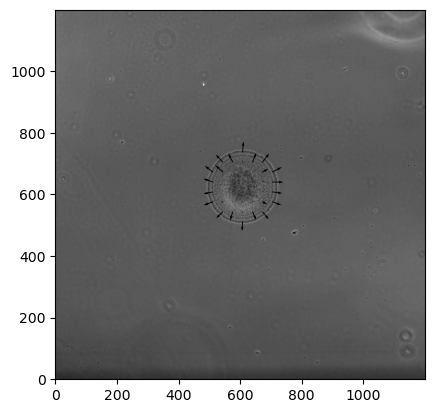

16


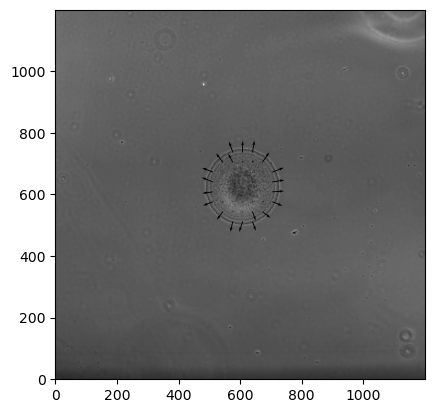

17


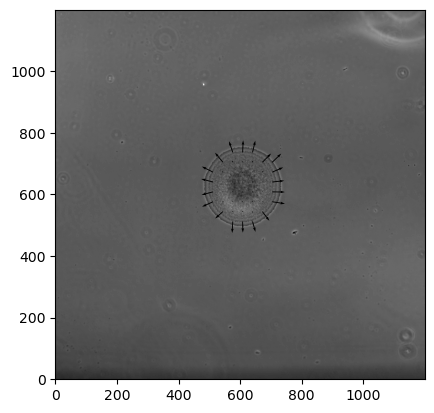

18


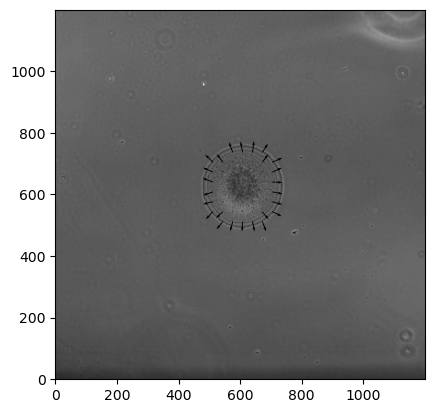

19


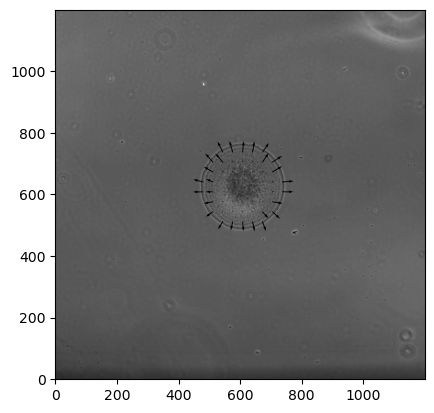

20


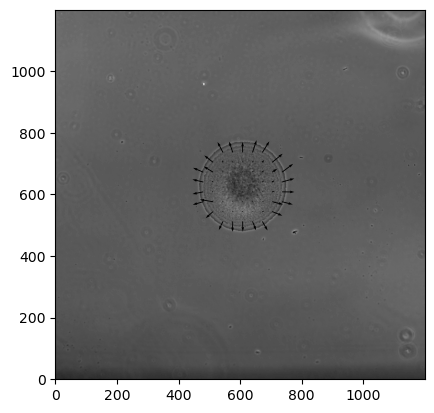

21


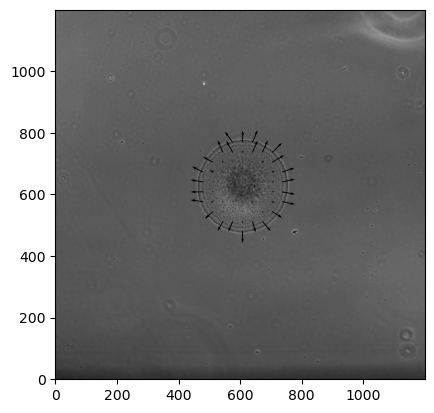

22


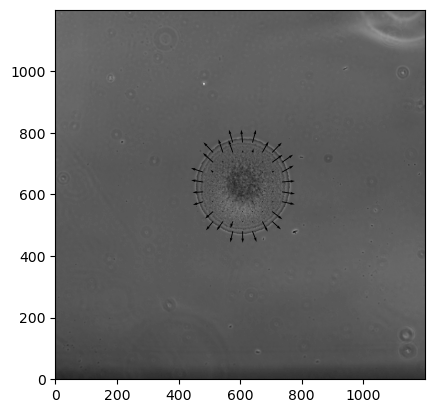

23


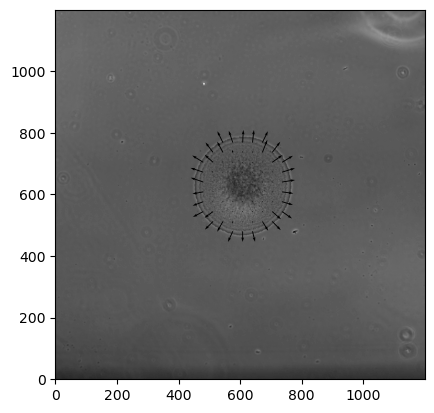

24


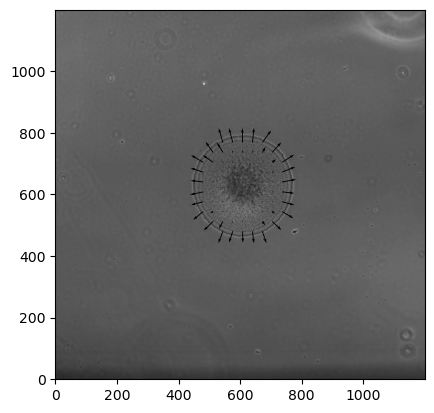

25


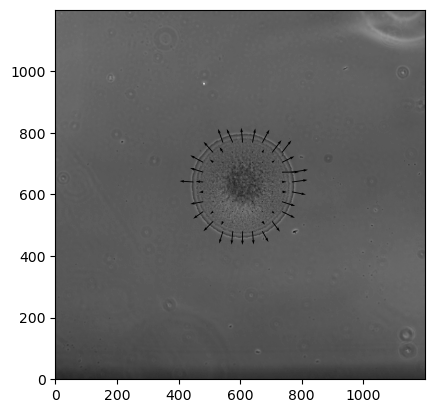

26


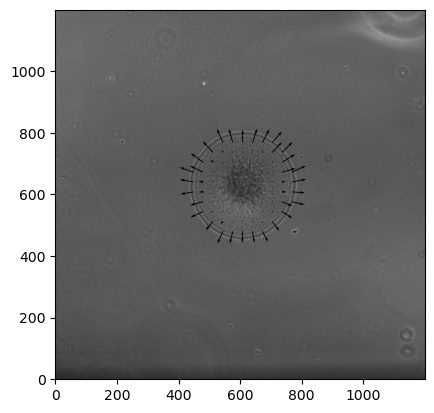

27


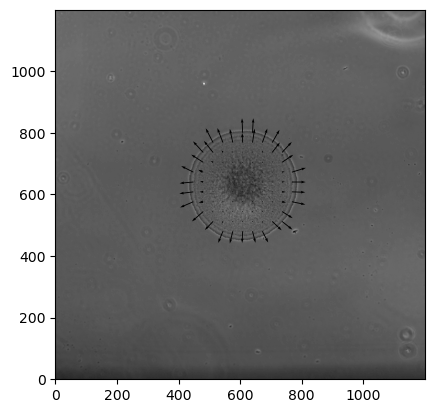

28


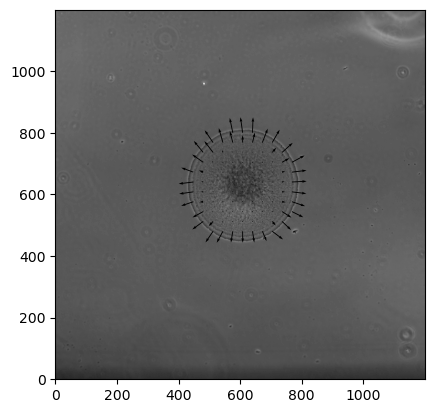

29


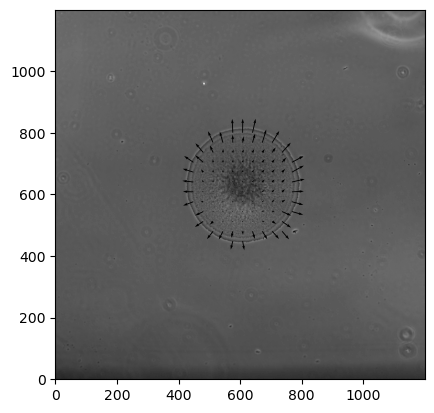

30


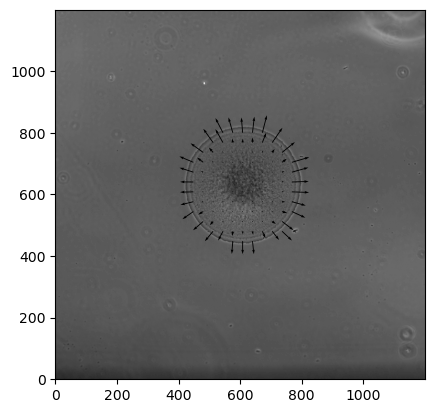

31


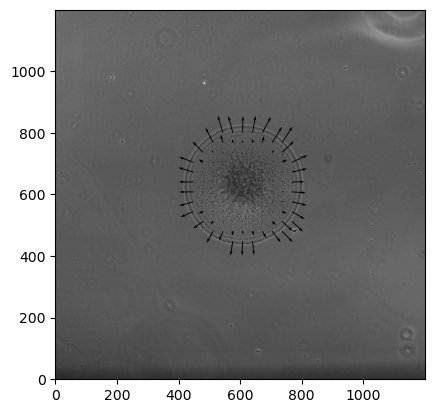

32


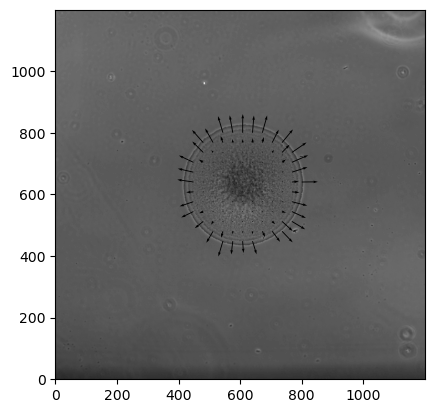

33


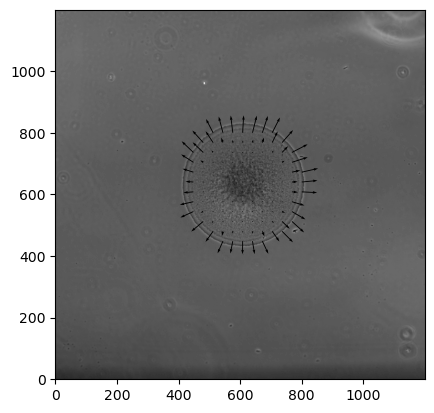

34


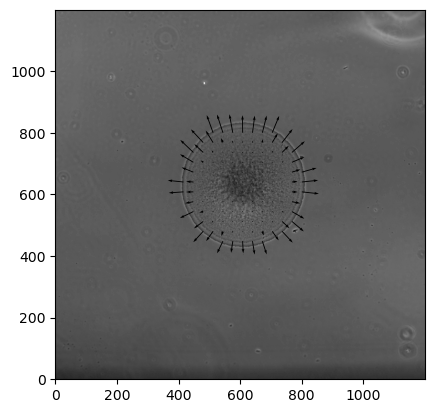

35


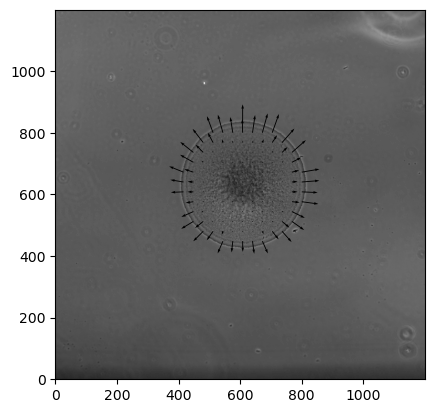

36


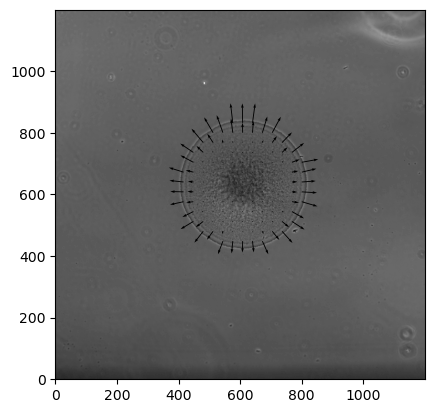

37


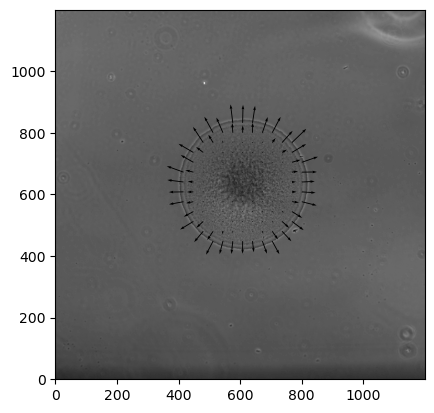

38


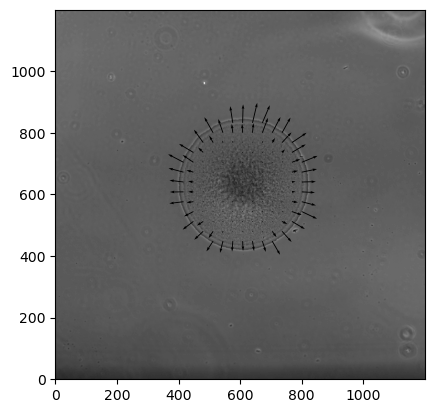

39


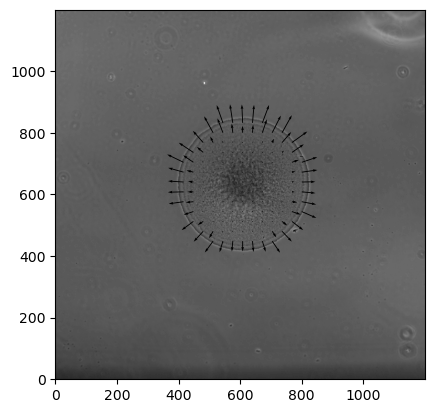

40


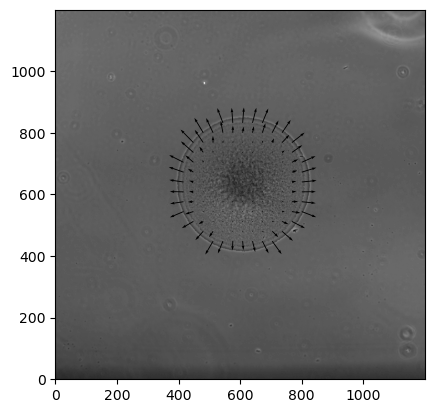

41


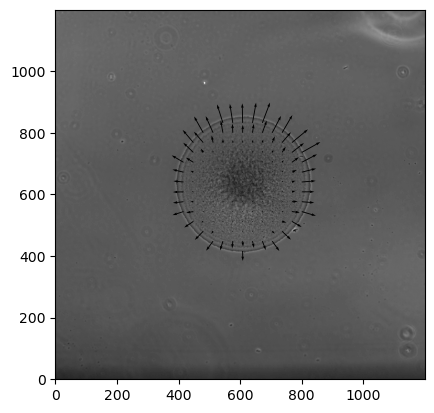

42


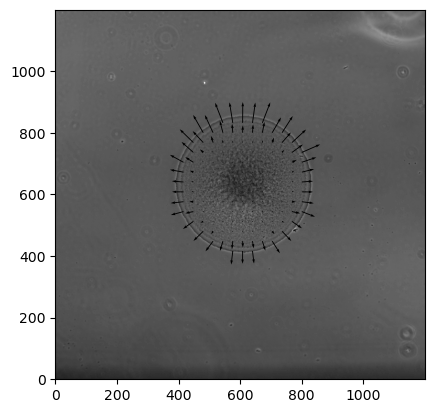

43


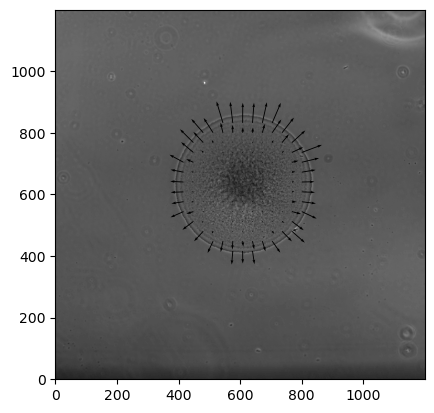

44


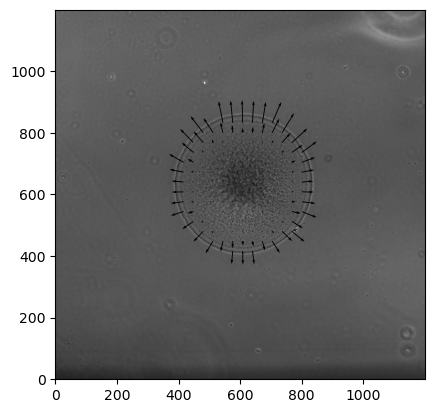

45


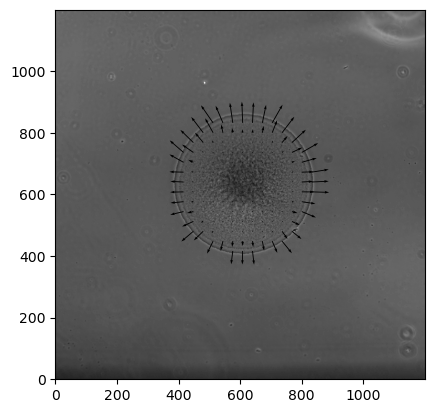

46


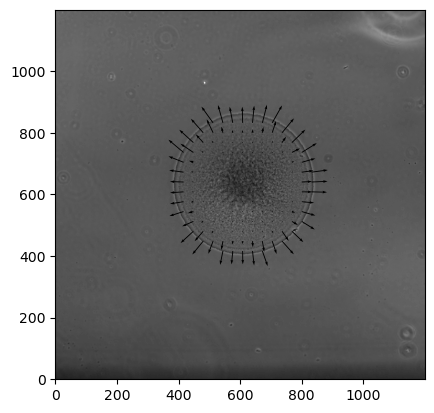

47


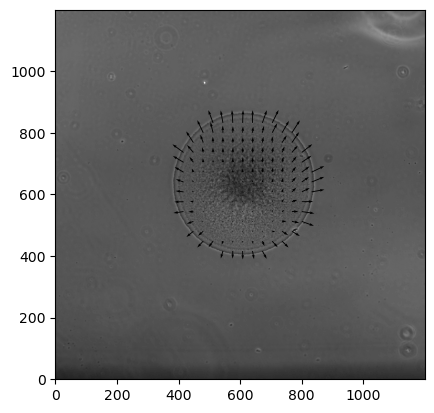

48


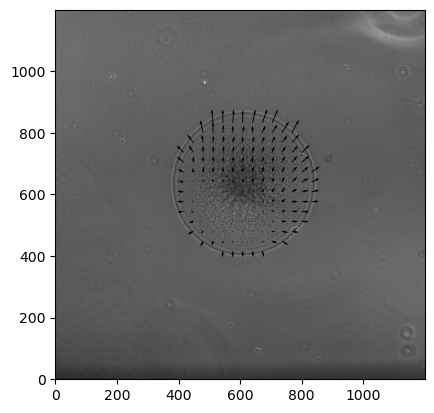

49


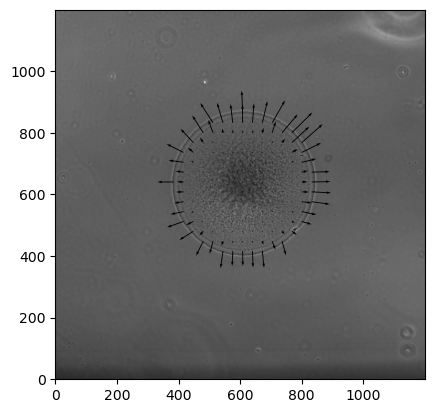

50


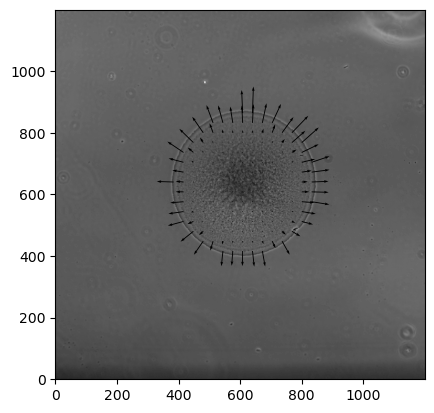

51


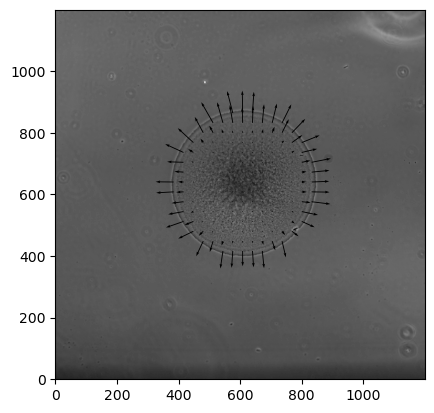

52


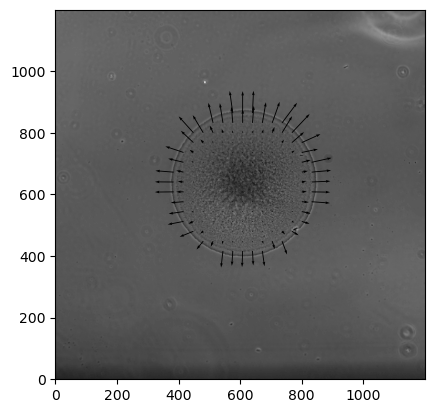

53


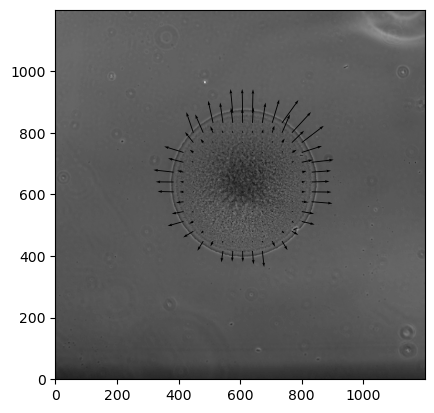

54


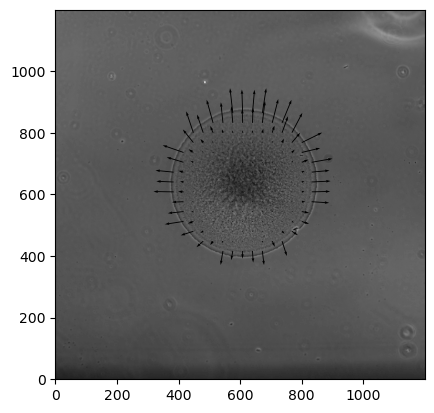

55


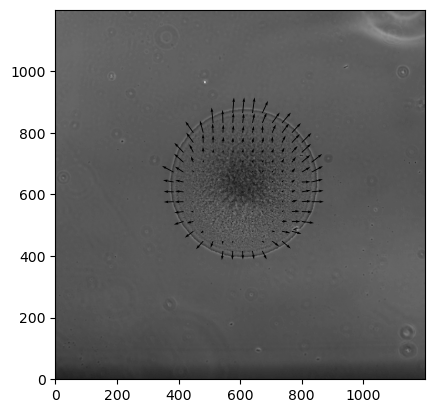

56


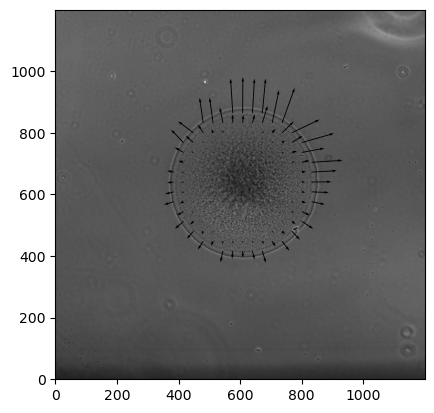

57


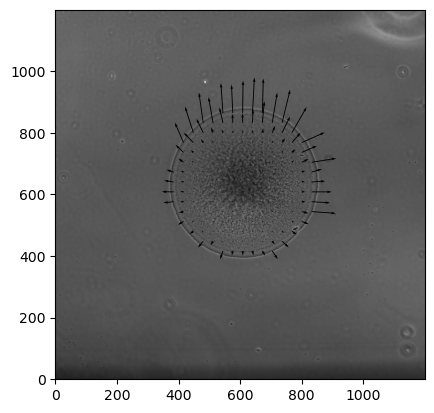

58


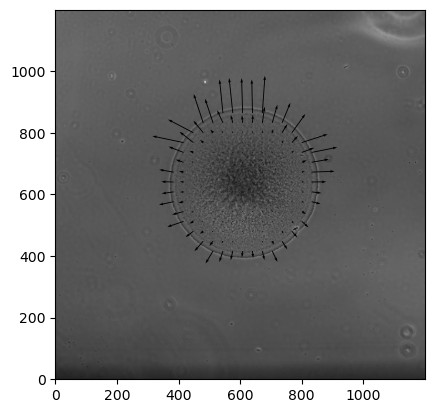

In [267]:
save_quivers('somepath', 'quiver_image_%04d.png', 'quiver_plain_%04d.png', 64, 64, nt, vel, pos, normed=False)

#### Process velocity

In [268]:
# Image frame to start from and step between frames
start_frame = 0
step = 1
nframes = 60
#pos = 0
# Position and velocity arrays from velocimetry

In [269]:
vel = np.load(os.path.join(path,scope_name,exp_date,velocity_folder,f'pos{position}','vel.np.npy'))
pos = np.load(os.path.join(path,scope_name,exp_date,velocity_folder,f'pos{position}','pos.np.npy'))

# Size of data
nx, ny, nt, _ = vel.shape

fname = f'{exp_date}_10x_1.0x_{dnas[vector]}_{scopes[scope_name]}_Pos{position}.ome.tif'
#im_all = imread(f'/media/c1046372/Expansion/Thesis GY/3. Analyzed files/Ti scope/2023_11_15/2023_11_15_10x_1.0x_{}_Ti_Pos0.ome.tif')
edt = np.load(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}','edt.npy'))
mask_all = imread(os.path.join(path,scope_name,exp_date,masks_folder,'mask_'+fname))
mask_all = mask_all > 0




In [270]:
_, edtnx, edtny = edt.shape
x, y = np.meshgrid(np.arange(edtnx), np.arange(edtny))

In [271]:
# Make arrays to store results
radpos = np.zeros((nt, nx, ny))
vmag = np.zeros((nt, nx, ny))
vrad = np.zeros((nt, nx, ny))
vtheta = np.zeros((nt, nx, ny))

In [272]:
vel.shape

(37, 37, 59, 2)

In [273]:
# Process the data and save results
for frame in range(nt):
    print(f'Processing frame {frame}')

    mask = mask_all[start_frame + frame * step + 1, :, :]
    cx = x[mask > 0].mean()
    cy = y[mask > 0].mean()

    vx = vel[:, :, frame, 0]
    vy = vel[:, :, frame, 1]

    # Subtract drift from velocities
    vx -= np.nanmean(vx)
    vy -= np.nanmean(vy)

    # Compute distance of each pixel from colony edge
    #edt[frame, :, :] = distance_transform_edt(mask)
    # edt[frame,:,:] = distance_transform_edt(mask_all[frame*step,:,:])

    # Get direction to colony edge as negative of gradient of distance
    gradx, grady = np.gradient(edt[start_frame + frame * step + 1, :, :])
    gradx[mask == 0] = np.nan
    grady[mask == 0] = np.nan
    px = pos[:, :, frame, 0].astype(int)
    py = pos[:, :, frame, 1].astype(int)
    pnorm = np.sqrt((px - cx) ** 2 + (py - cy) ** 2)

    gx = np.zeros((nx, ny))
    gy = np.zeros((nx, ny))
    for ix in range(nx):
        for iy in range(ny):
            gx[ix, iy] = -np.nanmean(gradx[px[ix, iy]:px[ix, iy] + 64, py[ix, iy]:py[ix, iy] + 64])
            gy[ix, iy] = -np.nanmean(grady[px[ix, iy]:px[ix, iy] + 64, py[ix, iy]:py[ix, iy] + 64])
            #gx[ix, iy] = -np.nanmean(gradx[px[ix, iy]:px[ix, iy] + 32, py[ix, iy]:py[ix, iy] + 32])
            #gy[ix, iy] = -np.nanmean(grady[px[ix, iy]:px[ix, iy] + 32, py[ix, iy]:py[ix, iy] + 32])
            
            # radpos[frame,ix,iy] = np.nanmean(edt[frame, px[ix,iy]-32:px[ix,iy]+32, py[ix,iy]-32:py[ix,iy]+32])
    # Compute magnitude of velocities in radial direction
    velnorm = np.sqrt(vx ** 2 + vy ** 2)
    gnorm = np.sqrt(gx ** 2 + gy ** 2)
    vmag[frame, :, :] = vx * gx + vy * gy
    vrad[frame, :, :] = vmag[frame, :, :] / velnorm / gnorm
    vperp = vx * gy - vy * gx
    vtheta[frame, :, :] = vperp / velnorm / gnorm

    # Radial position of each grid square
    radpos[frame, :, :] = edt[frame, px + 16, py + 16]
    #radpos[frame, :, :] = edt[frame, px + 8, py + 8]

# Area and estimated radius of colony
# area = mask_all[start_frame:start_frame + nt*step:step,:,:].sum(axis=(1,2))
#area = mask_all[start_frame:start_frame + nt * step:step, :, :].sum(axis=(1, 2))
#radius = np.sqrt(area / np.pi)

# Save results


Processing frame 0
Processing frame 1
Processing frame 2
Processing frame 3


/tmp/ipykernel_83532/1994497289.py:32: RuntimeWarning: Mean of empty slice
  gx[ix, iy] = -np.nanmean(gradx[px[ix, iy]:px[ix, iy] + 64, py[ix, iy]:py[ix, iy] + 64])
/tmp/ipykernel_83532/1994497289.py:33: RuntimeWarning: Mean of empty slice
  gy[ix, iy] = -np.nanmean(grady[px[ix, iy]:px[ix, iy] + 64, py[ix, iy]:py[ix, iy] + 64])


Processing frame 4
Processing frame 5
Processing frame 6
Processing frame 7
Processing frame 8
Processing frame 9
Processing frame 10
Processing frame 11
Processing frame 12
Processing frame 13
Processing frame 14
Processing frame 15
Processing frame 16
Processing frame 17
Processing frame 18
Processing frame 19
Processing frame 20
Processing frame 21
Processing frame 22
Processing frame 23
Processing frame 24
Processing frame 25
Processing frame 26
Processing frame 27
Processing frame 28
Processing frame 29
Processing frame 30
Processing frame 31
Processing frame 32
Processing frame 33
Processing frame 34
Processing frame 35
Processing frame 36
Processing frame 37
Processing frame 38
Processing frame 39
Processing frame 40
Processing frame 41
Processing frame 42
Processing frame 43
Processing frame 44
Processing frame 45
Processing frame 46
Processing frame 47
Processing frame 48
Processing frame 49
Processing frame 50
Processing frame 51
Processing frame 52
Processing frame 53
Proces

In [274]:
vmag.shape

(59, 37, 37)

In [275]:
radpos.shape

(59, 37, 37)

In [276]:
vrad.shape

(59, 37, 37)

In [277]:
vtheta.shape

(59, 37, 37)

In [278]:

path_save = os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}')
np.save(os.path.join(path_save,'radpos.npy'), radpos)
#np.save(os.path.join(path_save,'radpos.npy')'results/edt.npy', edt)
np.save(os.path.join(path_save,'vmag.npy'), vmag)
np.save(os.path.join(path_save,'vrad.npy'), vrad)
np.save(os.path.join(path_save,'vtheta.npy'), vtheta)
#np.save(os.path.join(path_save,'radpos.npy')'results/area.npy', area)
#np.save(os.path.join(path_save,'radpos.npy')'results/radius.npy', radius)

#### Fit velocity

In [279]:
# start frame from which velocimetry started
start_frame = 0
# time to which start fitting the data
t0 = 10
tf = 59
# offset = 0

# time to which stop fitting the data
#end_frame = 40
step = 1

In [280]:
# Normalize velocity by edge vel
#os.path.join(path,scope_name,exp_date,results_folder,f'pos{pos}', 'vmag.npy')
vmag = np.load(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'vmag.npy'))
vmag = vmag[t0:tf, :, :]
nt, nx, ny = vmag.shape


vfront = np.load(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'vfront.npy'))
rmax = np.load(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'radius.npy'))

idx = np.arange(start_frame+t0,nt+start_frame+t0)

vfront = vfront[idx]
rmax = rmax[idx]


#vfront = vfront[:-1]
#idx = np.where((vfront > 3) * (rmax[1:] > 128))[0]

print(vfront.shape)

(49,)


In [281]:
vfront.shape

(49,)

In [282]:
rmax.shape

(49,)

In [283]:
idx

array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58])

In [284]:
svmag = np.zeros_like(vmag) + np.nan
for t in range(0,nt):
    for ix in range(1, nx - 1):
        for iy in range(1, ny - 1):
            svmag[t, ix, iy] = np.nanmean(vmag[t, ix - 1:ix + 2, iy - 1:iy + 2])

nvmag = np.zeros_like(svmag)
for frame in range(0,nt):
    #nvmag[frame, :, :] = svmag[frame, :, :] / vfront[frame * step + start_frame]
    nvmag[frame, :, :] = svmag[frame, :, :] / vfront[frame * step]


radpos = np.load(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'radpos.npy'))
radpos = radpos[idx, :, :]
# nvmag[~np.isnan(radpos)] = np.nan
# svmag[~np.isnan(radpos)] = np.nan

print("Size of svmag array along axis 0:", svmag.shape[0])

/tmp/ipykernel_83532/2007238550.py:5: RuntimeWarning: Mean of empty slice
  svmag[t, ix, iy] = np.nanmean(vmag[t, ix - 1:ix + 2, iy - 1:iy + 2])


Size of svmag array along axis 0: 49


In [285]:
edt = np.load(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'edt.npy'))
edt = edt[idx, :, :]
res = least_squares(residual_func(edt, svmag, nt, nx, ny), x0=(np.log(50),))
r0 = np.exp(res.x[0])
C = 0  # res.x[1]

np.save(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'r0.npy'), r0)

print(f'r0 = {r0}, C = {C}')

r0 = 34.961402321984465, C = 0


In [286]:
edt.shape

(49, 1200, 1200)

In [289]:
r0 = 34.961402321984465

/tmp/ipykernel_83532/3711454480.py:24: RuntimeWarning: invalid value encountered in double_scalars
  model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
/tmp/ipykernel_83532/3711454480.py:28: RuntimeWarning: Mean of empty slice
  mean_model_vmag = np.nanmean(model_vmag)


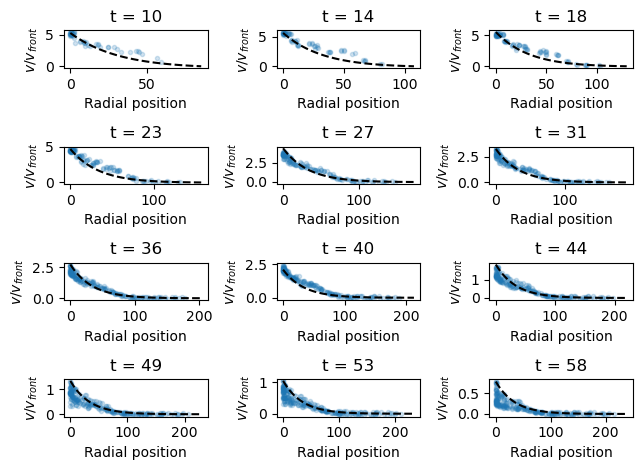

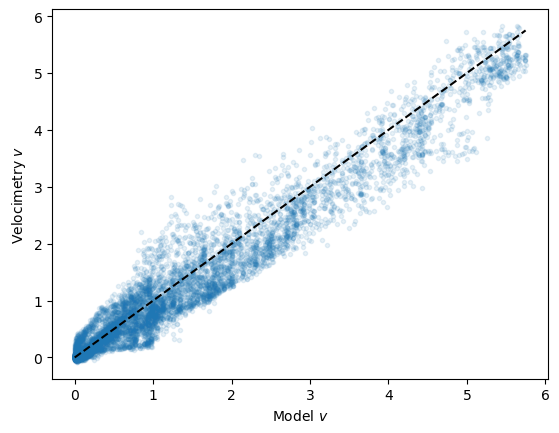

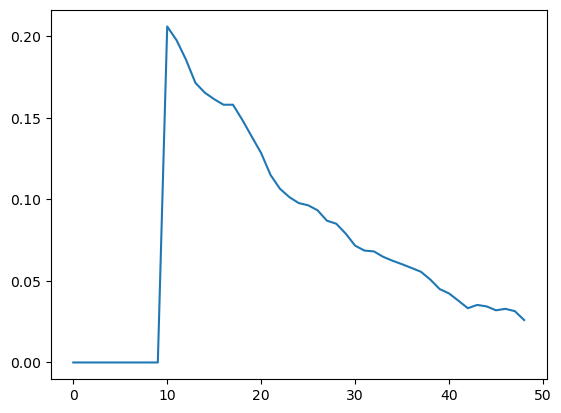

In [293]:
# Make a plot to see how good the fit is
colours = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
i = 0
times = np.linspace(0, nt - 1, 12).astype(int)  # [0,int(nt/3),int(2*nt/3),nt-1]
for t in times:
    plt.subplot(4, 3, i + 1)
    x_model = np.zeros((0,))
    y_model = np.zeros((0,))
    x_data = np.zeros((0,))
    y_data = np.zeros((0,))

    for ix in range(nx):
        for iy in range(ny):
            if not np.isnan(svmag[t, ix, iy]):
                r = edt[t, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                #r = edt[t, ix * 16:ix * 16 + 32, iy * 16:iy * 16 + 32]
                x_data = np.append(x_data, np.nanmean(r))
                y_data = np.append(y_data, svmag[t, ix, iy])
    plt.plot(x_data, y_data, '.', alpha=0.2)  # , color=colours[i])

    for r in np.linspace(0, rmax[t], 100):
        R = rmax[t]
        B = R / ((R - r0) + r0 * np.exp(-R / r0))    
        model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))

        #B = 1 / (1 - np.exp(-rmax[t] / r0))
        #model_vmag = 1 + B * (np.exp(-r / r0) - 1)
        mean_model_vmag = np.nanmean(model_vmag)
        x_model = np.append(x_model, np.nanmean(r))
        #y_model = np.append(y_model, vfront[start_frame + step * t] * mean_model_vmag)
        y_model = np.append(y_model, vfront[step * t] * mean_model_vmag)

    plt.plot(x_model, y_model, 'k--')  # , color=colours[i])

    i += 1

    plt.title(f't = {idx[t]}')
    plt.xlabel('Radial position')
    plt.ylabel('$v/v_{front}$')
plt.tight_layout()
plt.savefig(os.path.join(path,scope_name,exp_date,graphs_folder,f'pos{position}', 'vfront_rad.png'))
plt.show()

y_model = np.zeros((0,))
y_data = np.zeros((0,))
for t in range(0,nt):
    for ix in range(nx):
        for iy in range(ny):
            if not np.isnan(svmag[t, ix, iy]):
                r = edt[t, ix * 32:ix * 32 + 64, iy * 32:iy * 32 + 64]
                #r = edt[t, ix * 16:ix * 16 + 32, iy * 16:iy * 16 + 32]
                R = rmax[t]
                B = R / ((R - r0) + r0 * np.exp(-R / r0))    
                model_vmag = B * (((R - r - r0) * np.exp(-r / r0) + r0 * np.exp(-R / r0)) / (R - r))
                #B = 1 / (1 - np.exp(-rmax[t] / r0))
                #model_vmag = 1 + B * (np.exp(-r / r0) - 1)
                mean_model_vmag = np.nanmean(model_vmag)
                #y_model = np.append(y_model, vfront[start_frame + step * t] * mean_model_vmag)
                y_model = np.append(y_model, vfront[step * t] * mean_model_vmag)
                y_data = np.append(y_data, svmag[t, ix, iy])

plt.plot(y_model, y_data, '.', alpha=0.1)
plt.plot([0, y_model.max()], [0, y_model.max()], 'k--')
plt.xlabel('Model $v$')
plt.ylabel('Velocimetry $v$')
plt.savefig(os.path.join(path,scope_name,exp_date,graphs_folder,f'pos{position}', 'model_graph.png'))
# plt.xscale('log')
# plt.yscale('log')
plt.show()

mu0 = np.zeros((nt,))
for t in range(t0,nt):

    R = rmax[t]
    B = R / ((R - r0) + r0 * np.exp(-R / r0))
    mu0[t] = vfront[t] / r0 * B

    #B = 1 / (1 - np.exp(-rmax[t] / r0))
    #mu0[t] = 2 * vfront[step * t] / r0 * B

# The edge growth rate = 2 * edge velocity / r0 
plt.plot(mu0)
plt.savefig(os.path.join(path,scope_name,exp_date,graphs_folder,f'pos{position}', 'mu0_profile.png'))
plt.show()
np.save(os.path.join(path,scope_name,exp_date,results_folder,f'pos{position}', 'mu0.npy'), mu0)
